In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
%config InlineBackend.figure_format='svg'
# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [10]:
df = pd.read_csv('rfm_data.csv')

In [11]:
# датасет состоит из следующих колонок: дата заказа, id заказа, имя клиента, сумма заказа
df.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_date   5009 non-null   datetime64[ns]
 1   order_id     5009 non-null   object        
 2   customer     5009 non-null   object        
 3   grand_total  5009 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.7+ KB


In [13]:
# меняем формат данных в датасете
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_id'] = df['order_id'].apply(str)
df['customer'] = df['customer'].apply(str)

In [15]:
# выясняем за какой период датасет
df['order_date'].describe()

/tmp/ipykernel_246/948275481.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['order_date'].describe()


count                    5009
unique                   1238
top       2013-09-06 00:00:00
freq                       19
first     2011-01-04 00:00:00
last      2014-12-31 00:00:00
Name: order_date, dtype: object

In [16]:
# выясняем дату последнего действия, залогированного в датасете. От это даты будут отсчитываться дни с моменты последней покупки у пользователей.
last_date = df['order_date'].max()

In [18]:
# создаем новый датасет, который будет включать в себя:
# Recency - количество дней с последнего заказа
# Frequency - количество заказов
# Monetary - общая сумма по всем заказам

In [27]:
rfmTable = df.groupby('customer', as_index = False).agg({'order_date': lambda x: (last_date - x.max()).days, # Recency
                                      'order_id': lambda x: len(x),      # Frequency
                                      'grand_total': lambda x: x.sum()}) # Monetary

In [28]:
rfmTable.head()

,customer,order_date,order_id,grand_total
0,Aaron Bergman,415,3,887
1,Aaron Hawkins,12,7,1744
2,Aaron Smayling,88,7,3050
3,Adam Bellavance,54,8,7756
4,Adam Hart,34,10,3249


In [29]:
# приведем колонку order к формату int, переименуем колонки
rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns = {'order_date':'recency',
                           'order_id':'frequency',
                           'grand_total':'monetary_value'}, inplace = True)

In [30]:
rfmTable.head()

,customer,recency,frequency,monetary_value
0,Aaron Bergman,415,3,887
1,Aaron Hawkins,12,7,1744
2,Aaron Smayling,88,7,3050
3,Adam Bellavance,54,8,7756
4,Adam Hart,34,10,3249


In [ ]:
# делим распределение пользователей по каждой из метрик на равные группы для RFM-анализа. Для этого посчитаем квантили наших метрик

In [31]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [49]:
quantiles.head()

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [35]:
# получили пограничные значения, попадая в которые пользователю будет присвоен определенный класс для каждой из колонок

In [36]:
rfm_Segment = rfmTable

In [54]:
# функция для R класса, т.к его логига откличается от остальных - чем меньше значение Recency, тем лучше
def RClass(value,columns,quantiles):
    if value <= quantiles[columns][0.25]:
        return 1
    elif value <= quantiles[columns][0.50]:
        return 2
    elif value <= quantiles[columns][0.75]:
        return 3
    else:
        return 4
    
# функция для F и M класса, у них другая логика, чем выше значение тем лучше класс
def FMClass(value, columns, quantiles):
    if value <= quantiles[columns][0.25]:
        return 4
    elif value <= quantiles[columns][0.50]:
        return 3
    elif value <= quantiles[columns][0.75]:
        return 2
    else:
        return 1

In [55]:
# создаем отдельные колонки со значением сегментов, применяя к метриками соответствующие функции из пердыдущего шага
rfm_Segment['R_Quartile']=rfm_Segment['recency'].apply(RClass, args=('recency',quantiles))
rfm_Segment['F_Quartile']=rfm_Segment['frequency'].apply(FMClass, args=('frequency',quantiles))
rfm_Segment['M_Quartile']=rfm_Segment['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))


In [56]:
# складываем все классы вместе, чтобы получить финальный сегмент RFM

rfm_Segment['RFMClass'] = rfm_Segment.R_Quartile.map(str)\
                        + rfm_Segment.F_Quartile.map(str)\
                        + rfm_Segment.M_Quartile.map(str)


In [57]:
# итоговый датасет
rfm_Segment.head()

,customer,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,Aaron Bergman,415,3,887,4,4,4,444
1,Aaron Hawkins,12,7,1744,1,2,3,123
2,Aaron Smayling,88,7,3050,3,2,2,322
3,Adam Bellavance,54,8,7756,2,2,1,221
4,Adam Hart,34,10,3249,2,1,2,212


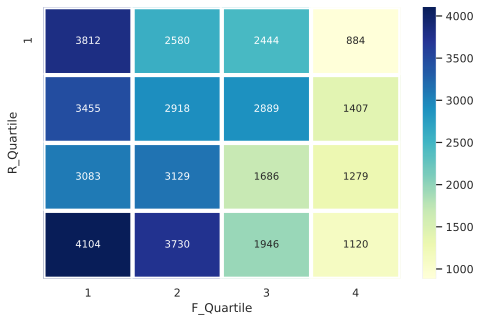

In [61]:
# с помощью seaborn библиотеки визуализируем распределение пользователей
# по оси х отображатеся F-класс, по оси y R-класс, а внутри ячеек медианной значение LTV в сегменте

viz = rfm_Segment.pivot_table(
                    index = 'R_Quartile',
                    columns = 'F_Quartile',
                    values = 'monetary_value',
                    aggfunc = np.median).applymap(int)
sns.heatmap(viz, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=4.15, annot_kws={'size':10},yticklabels=4);